In [1]:
import os
import pandas as pd
import numpy as np
import sklearn
import networkx as nx
import networkit as nk
import random

In [2]:
def get_graphs(path):
    items = os.listdir(path)
    return [nx.read_edgelist(os.path.join(path, f), delimiter = "\t") for f in os.listdir(path)]

In [3]:
pred_dir = "/home/alex/Projects/GRAN_social/exp/GRAN/FACEBOOK/pred_graphs"
sample_dir = "/home/alex/Projects/GRAN_social/exp/GRAN/FACEBOOK/sample_graphs"
rmat_dir = "/home/alex/Projects/GRAN_social/exp/GRAN/FACEBOOK/rmat_graphs"

rmat_graphs = get_graphs(rmat_dir)
pred_graphs = get_graphs(pred_dir)
  # display the largest connected component for better visualization
vis_graphs = []
for gg in pred_graphs:
    CGs = [gg.subgraph(c) for c in nx.connected_components(gg)]
    CGs = sorted(CGs, key=lambda x: x.number_of_nodes(), reverse=True)
    vis_graphs += [CGs[0]]
    
pred_graphs = vis_graphs
sample_graphs = get_graphs(sample_dir)

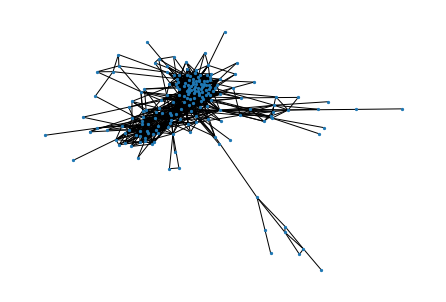

In [4]:
nx.draw(pred_graphs[5], node_size = 5)

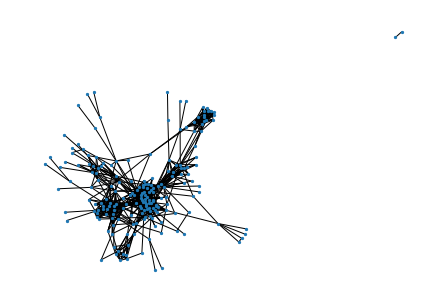

In [5]:
nx.draw(sample_graphs[5], node_size = 5)

graph laid out
simulation run


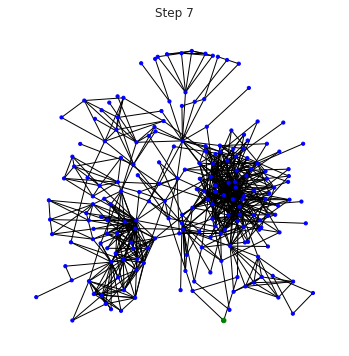

In [6]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation, PillowWriter 



def SIR_full(G,T = 400, HM = 0.025, Gamma = 7, Nb_inf_init = 1):
    """ function that runs a simulation of an SIR model on a network.
    Args:
        Gamma(float): recovery rate
        Beta(float): infection probability
        Rho(float): initial fraction of infected individuals
        T(int): number of time steps simulated
    """

    N = len(list(G.nodes()))

    s =   [N - Nb_inf_init] #np.zeros(T)
    inf = [Nb_inf_init] #np.zeros(T)
    r =   [0] #np.zeros(T)

    """Make a graph with some infected nodes."""
    for u in G.nodes():
        G.nodes[u]["state"] = [0]
        G.nodes[u]["TimeInfected"] = 0
        G.nodes[u]["noeux_associes"] = [n for n in G.neighbors(u)]

    init = random.sample(list(G.nodes()), Nb_inf_init)
    for u in init:
        G.nodes[u]["state"][0] = 1
        G.nodes[u]["TimeInfected"] = 1
    
    # running simulation
    is_ended = False
    t = 1
    while not is_ended:

        s.append(s[t-1])
        inf.append(inf[t-1])
        r.append(r[t-1])


        for u in G.nodes:
            
            current_state = G.nodes[u]["state"][t-1]
            
            if current_state == 0:
                G.nodes[u]["state"] += [0]
            elif current_state == 2:
                G.nodes[u]["state"] += [2]
            else:
                time_infected = len(np.argwhere(G.nodes[u]["state"]))
                
                if time_infected < Gamma:
                    G.nodes[u]["state"] += [1]
                else:
                    G.nodes[u]["state"] += [2]
                    
                    r[t] += 1
                    inf[t] += -1

        # check contagion
        for u in G.nodes:
            #if susceptible
            if G.nodes[u]["state"][t] == 0:
                
                for n in G.nodes[u]["noeux_associes"]:
                    if G.nodes[n]["state"][t] == 1: # if friend is infected
                        
                        if np.random.rand() < HM:
                            # print("this one is infected")
                            # print(G.nodes[u]["state"][t])
                            G.nodes[u]["state"][t] = 1
                            # print(G.nodes[u]["state"][t])
                            # print("\n")
                            inf[t] += 1
                            s[t] += -1
                            break

        if inf[t] == 0 or t == T: #
            is_ended = True
        t += 1

    return G


def simple_update(num, layout, G, ax):
    ax.clear()

    # Draw the graph with random node colors
    # print(num)
    
    # for node in list(G.nodes()):
    #     print(len(G.nodes[node]["state"]))
    
    step_states = [G.nodes[node]["state"][num] for node in list(G.nodes())]
    
    colormap = {0:"blue", 1:"red", 2:"green"}
    
    colors = []
    for s in step_states:
        colors.append(colormap[s])
    
    sizemap = {0:10, 1:40, 2:20}
    sizes = []
    for s in step_states:
        sizes.append(sizemap[s])
    # print(random_colors)
    # random_colors = np.random.randint(2, size=n)
    nx.draw(G, pos=layout, node_color=colors, ax=ax, node_size = sizes)

    # Set the title
    ax.set_title("Step {}".format(num))
    
# def sir_update(G)


def simple_animation(G):

    # Build plot
    fig, ax = plt.subplots(figsize=(6,6))

#     # Create a graph and layout
#     n = 30 # Number of nodes
#     m = 70 # Number of edges
#     G = nx.gnm_random_graph(n, m)
    # nsteps = len()
    # layout = nx.spring_layout(G, iterations = 100)
    layout = nx.nx_pydot.graphviz_layout(G, prog="neato")
    print("graph laid out")
    G = SIR_full(G)
    print("simulation run")

    # n_steps = len(out_graph.nodes["0"]["state"])
    # print(n_steps)
    # print(np.arange(n_steps-1).shape)
    
    for node in list(G.nodes()):
        n_steps = len(G.nodes[node]["state"])
    
    
    # writergif = animation.FFMpegWriter(fps=30) 
    # anim.save(f, writer=writergif)
    
    ani = animation.FuncAnimation(fig, simple_update, frames=np.arange(n_steps), fargs=(layout, G, ax))
    ani.save('FACEBOOK_1.gif', dpi = 300, fps = 5)
    plt.show()

simple_animation(sample_graphs[15])

# nx.draw(sample_graphs[15])
# plt.show()

# out_graph = SIR_ani_update(sample_graphs[15])
# for node in list(out_graph.nodes()):
#     print(out_graph.nodes[node])
#     print("\n")

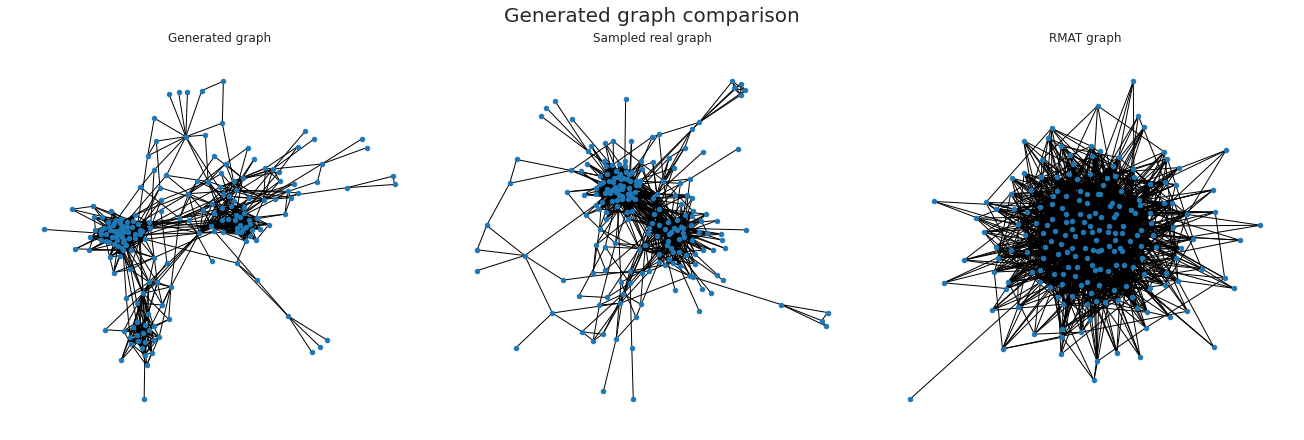

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, figsize = (18,6), constrained_layout = True)

gen = pred_graphs[10]
sam = sample_graphs[12]
rma = rmat_graphs[0]

nx.draw(gen, ax = ax1, node_size = 20, )
nx.draw(sam, ax = ax2, node_size = 20)
nx.draw(rma, ax = ax3, node_size = 20)

ax1.set_title("Generated graph")
ax2.set_title("Sampled real graph")
ax3.set_title("RMAT graph")

plt.suptitle("Generated graph comparison", fontsize = 20)

plt.savefig("Generation comparison")
plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160/160 [00:12<00:00, 12.90it/s]


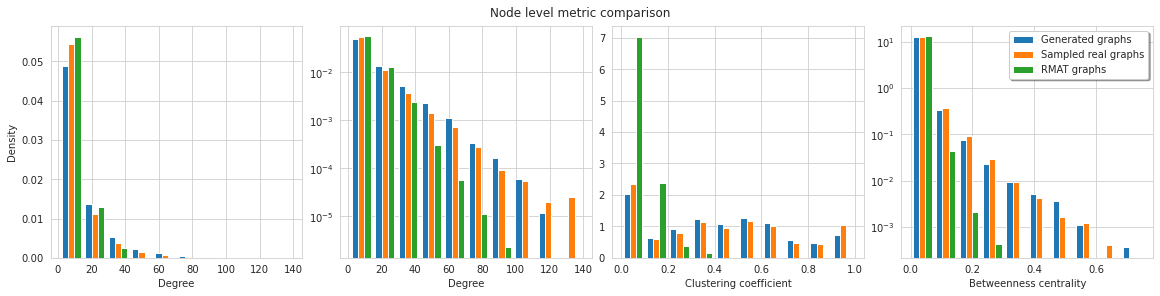

In [8]:
from tqdm import tqdm
def get_values(G, fn):
    cluster_dict = fn(G)
    
    if type(cluster_dict) == dict:
        # print(cluster_dict)
        keys = list(cluster_dict.keys())

        return [cluster_dict[k] for k in keys]
    elif type(list(cluster_dict)[0]) == tuple:
        return [tup[1] for tup in list(cluster_dict)]

def all_values(graphlist, fn = nx.clustering):
    clustering_values = []
    for g in tqdm(graphlist):
        clustering_values += get_values(g, fn)
    return clustering_values

def draw_comparison(pred_graphs, sample_graphs, rmat_graphs, fn, ax, ylabel, xlabel, islog = True):

    ax.hist([all_values(pred_graphs, fn = fn), all_values(sample_graphs, fn = fn), all_values(rmat_graphs, fn = fn)],
             label=["Generated graphs", "Sampled real graphs", "RMAT graphs"], density = True)

    # ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    if islog:
        ax.set_yscale("log")
    # ax.legend(shadow = True)
    return ax
    
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, nrows = 1, figsize = (16, 4), constrained_layout = True)

ax1 = draw_comparison(pred_graphs, sample_graphs, rmat_graphs, nx.degree, ax1, "Density", "Degree", islog = False)
ax2 = draw_comparison(pred_graphs, sample_graphs, rmat_graphs, nx.degree, ax2, "Density", "Degree")
ax3 = draw_comparison(pred_graphs, sample_graphs, rmat_graphs, nx.clustering, ax3, "Density", "Clustering coefficient", islog = False)
ax4 = draw_comparison(pred_graphs, sample_graphs, rmat_graphs, nx.betweenness_centrality, ax4, "Density", "Betweenness centrality")

ax1.set_ylabel("Density")
ax4.legend(shadow = True)

plt.suptitle("Node level metric comparison", fontsize = 12)

plt.savefig("Node_level_comparisons.png")
plt.show()